In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
cwd = os.getcwd()

In [3]:
parent_dir = os.path.dirname(cwd)

In [4]:
train_files = joblib.load(f'{parent_dir}/FEMH_train_files.pkl')
test_files = joblib.load(f'{parent_dir}/FEMH_test_files.pkl')

In [5]:
femh_df = pd.read_csv(f"{parent_dir}/Raw Features/FeatureStates_FEMH.csv", index_col=0)
femh_df['filename'] = femh_df['file'].str.split('.', expand=True)[0]
femh_df = femh_df.drop(['file'], axis=1)
femh_df.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,pathology,filename
0,0.198858,-0.671097,-0.553800,0.430371,0.689427,0.451664,0.513923,-0.669326,3.029441,-0.140924,...,-0.467423,0.029338,0.752360,-0.578080,1.039529,0.202895,1.363360,0.883992,Atrophy,Atrophy-00002mg
1,0.545076,-0.047681,-1.163096,0.268823,0.509433,-0.136339,0.201685,-0.742708,-0.094480,0.041155,...,1.091321,-0.360934,0.273519,-0.935269,-0.079642,-0.262875,-0.492177,0.851083,Atrophy,Atrophy-0001297
2,0.298088,-0.969536,-1.342669,0.438397,-0.010687,0.756730,0.694832,2.412334,0.193469,2.678018,...,-1.588670,-1.013131,0.818641,4.835070,-0.309830,0.503137,1.045041,0.546520,Atrophy,Atrophy-0001apo
3,0.297540,-0.991699,2.728217,-0.110462,0.275403,0.368062,-0.597715,-0.435604,6.930976,-0.512924,...,-1.465304,-1.550032,0.370240,0.287871,1.318349,0.779946,2.578023,0.359360,Atrophy,Atrophy-0001qd3
4,0.569070,-0.708248,-0.532420,0.829588,0.291864,-0.042466,-0.483135,-1.057416,2.885130,0.608033,...,1.912285,1.891305,0.523399,-0.637222,0.400236,0.318714,-0.948448,0.026111,Atrophy,Atrophy-0002ipt


In [6]:
demographics = pd.read_pickle(f'{parent_dir}/Audio/medicalhistory.pkl')
demographics = demographics.drop(['ID', 'Disease category', 'pathology'], axis=1)
# demographics = demographics[['Sex', 'Age', 'filename']]
# demographics = demographics.drop(['Sex', 'Age'], axis=1)
demographics.head()

,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,Heartburn,Choking,Eye dryness,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,filename
0,1,97,0,0,0,0,0,0,1,0,...,1,2,0,0,0,0,0,0,12,Atrophy-00002mg
1,1,86,0,0,0,0,0,0,1,0,...,1,4,0,1,0,0,0,1,36,Atrophy-0001297
2,2,45,0,0,0,1,0,0,0,0,...,1,3,0,0,0,0,0,0,16,Atrophy-0001apo
3,1,75,1,1,0,0,1,0,0,0,...,1,3,0,0,1,0,0,0,19,Atrophy-0001qd3
4,1,64,0,0,0,1,0,0,0,0,...,1,2,0,0,1,0,0,0,34,Atrophy-0002ipt


In [7]:
df = pd.merge(femh_df, demographics, on='filename', how='inner')
df.head()
# df = femh_df.copy()

,0,1,2,3,4,5,6,7,8,9,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,0.198858,-0.671097,-0.553800,0.430371,0.689427,0.451664,0.513923,-0.669326,3.029441,-0.140924,...,2,1,2,0,0,0,0,0,0,12
1,0.545076,-0.047681,-1.163096,0.268823,0.509433,-0.136339,0.201685,-0.742708,-0.094480,0.041155,...,2,1,4,0,1,0,0,0,1,36
2,0.298088,-0.969536,-1.342669,0.438397,-0.010687,0.756730,0.694832,2.412334,0.193469,2.678018,...,3,1,3,0,0,0,0,0,0,16
3,0.297540,-0.991699,2.728217,-0.110462,0.275403,0.368062,-0.597715,-0.435604,6.930976,-0.512924,...,2,1,3,0,0,1,0,0,0,19
4,0.569070,-0.708248,-0.532420,0.829588,0.291864,-0.042466,-0.483135,-1.057416,2.885130,0.608033,...,5,1,2,0,0,1,0,0,0,34


In [8]:
df['pathology'].value_counts()

pathology
Polyp                       202
Nodules                     200
Atrophy                     189
Cyst                        175
Vocal paresis               164
Vocal palsy                 164
Reinke’s edema              144
Sulcus                      127
Muscle tension dysphonia    117
Presbyphonia                115
Vocal process granuloma      86
Fibrous mass                 84
Ulcer                        64
Spasmodic dysphonia          34
Laryngeal cancer             31
Dysplasia                    29
Papilloma                    28
Tremor                       18
Scar                         15
Varix                        14
Name: count, dtype: int64

In [9]:
# Pathologies to be replaced with "Malignant"
malignant_pathologies = ['Laryngeal cancer', 'Dysplasia']

# Replace specified pathologies with "Malignant"
df['pathology'] = df['pathology'].apply(lambda x: 'Malignant' if x in malignant_pathologies else 'Benign')

In [10]:
df['pathology'].value_counts()

pathology
Benign       1940
Malignant      60
Name: count, dtype: int64

In [11]:
train_df = df[df['filename'].isin(train_files)]
train_df = train_df.reset_index(drop=True)

In [12]:
X_train = train_df.drop(['pathology', 'filename'], axis=1)
y_train = train_df['pathology']

In [13]:
X_train.shape

(1340, 538)

In [14]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping the class labels to their weights
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
class_weight_dict

{'Benign': 0.5134099616858238, 'Malignant': 19.142857142857142}

In [15]:
audio_features = femh_df.columns.drop(['pathology', 'filename'])
audio_features

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)

In [16]:
symptom_features = X_train.columns.drop(audio_features)
symptom_features

Index(['Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'Heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10'],
      dtype='object')

In [17]:
# Define the preprocessing and feature selection for audio features
audio_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer step
    ('scaler', StandardScaler()),  # Scaling step
    ('feature_selection', SelectFromModel(DecisionTreeClassifier(random_state=42)))  # Feature Selection
])

In [18]:
# Define the preprocessing for symptoms (imputation and scaling only)
symptom_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Imputer step
    ('scaler', StandardScaler())  # Scaling step
])

In [19]:
# Combine the preprocessing and feature selection for audio features with symptom preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', audio_preprocessing, audio_features),
        ('symptoms', symptom_preprocessing, symptom_features)
    ]
)

In [20]:
pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', SVC(random_state=42, class_weight=class_weight_dict, probability=True)) # MLP Classifier step
])

In [21]:
param_grid ={'classifier__C': [0.1, 1, 10, 100, 1000],  
              'classifier__gamma': ['scale', 'auto', 1e-4, 1e-3, 1e-2, 1e-1, 1], 
              'classifier__degree': [2, 3, 4],
              'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

In [22]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy', verbose=3, return_train_score=True)

In [23]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
[CV 1/5] END classifier__C=0.1, classifier__degree=2, classifier__gamma=scale, classifier__kernel=linear;, score=(train=0.970, test=0.871) total time=   0.9s
[CV 2/5] END classifier__C=0.1, classifier__degree=2, classifier__gamma=scale, classifier__kernel=linear;, score=(train=0.972, test=0.703) total time=   0.8s
[CV 3/5] END classifier__C=0.1, classifier__degree=2, classifier__gamma=scale, classifier__kernel=linear;, score=(train=0.975, test=0.583) total time=   1.0s
[CV 4/5] END classifier__C=0.1, classifier__degree=2, classifier__gamma=scale, classifier__kernel=linear;, score=(train=0.973, test=0.616) total time=   1.1s
[CV 5/5] END classifier__C=0.1, classifier__degree=2, classifier__gamma=scale, classifier__kernel=linear;, score=(train=0.970, test=0.713) total time=   0.6s
[CV 1/5] END classifier__C=0.1, classifier__degree=2, classifier__gamma=scale, classifier__kernel=poly;, score=(train=0.987, test=0.776) total tim

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('audio',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('feature_selection',
                                                                                          SelectFromModel(estimator=DecisionTreeClassifier(random_state=42)))]),
                                                                         Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507',...
                                        SVC(class_weight={'Benign': 0.5134099616858238,
                                                          'Malignant': 19.142857142857142},
                                            probability=True,
                                            random_state=42))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000],
                         'classifier__degree': [2, 3, 4],
                         'classifier__gamma': ['scale', 'auto', 0.0001, 0.001,
                                               0.01, 0.1, 1],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid']},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [24]:
# Best parameters from GridSearchCV
print(f'Best parameters: {grid_search.best_params_}')

# Best estimator from GridSearchCV
best_pipeline = grid_search.best_estimator_

Best parameters: {'classifier__C': 1, 'classifier__degree': 2, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [25]:
cv_results = grid_search.cv_results_

best_index = grid_search.best_index_
print("Cross-validation results for the best parameters:")

print(f"Mean test score: {cv_results['mean_test_score'][best_index]}")
print(f"Mean train score: {cv_results['mean_train_score'][best_index]}")

Cross-validation results for the best parameters:
Mean test score: 0.7871373836891078
Mean train score: 0.8416529830322933


In [26]:
joblib.dump(grid_search, 'SVM_FeatureStates_Age_Sex_Symptoms.pkl', compress=True)

['SVM_FeatureStates_Age_Sex_Symptoms.pkl']

# Test - holdout

In [27]:
test_df = df[df['filename'].isin(test_files)]
test_df = test_df.reset_index(drop=True)

In [28]:
X_test = test_df.drop(['pathology', 'filename'], axis=1)
y_test = test_df['pathology']

In [29]:
# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Evaluate the classifier
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.779


In [30]:
pathologies = df['pathology'].unique()
pathologies

array(['Benign', 'Malignant'], dtype=object)

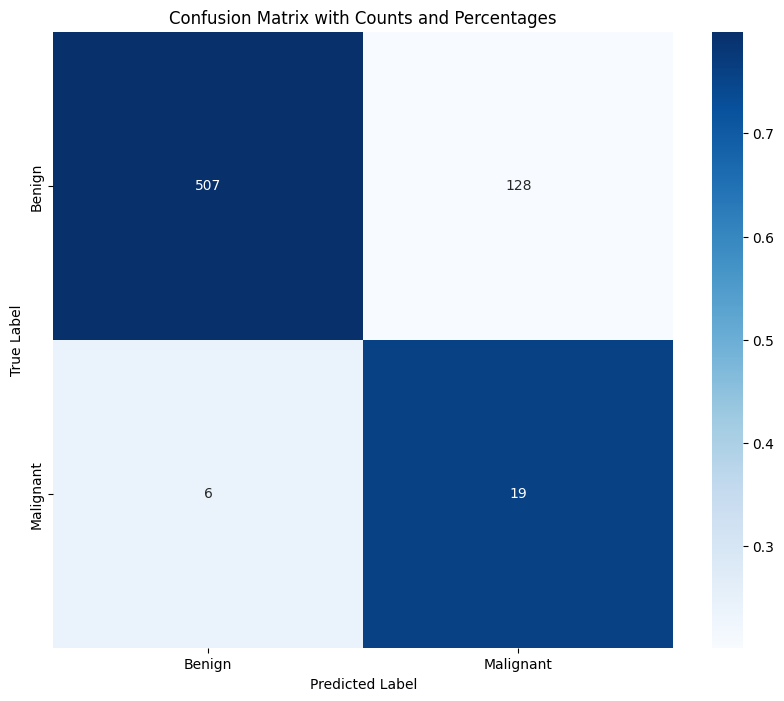

In [31]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pathologies)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', xticklabels=pathologies, yticklabels=pathologies)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()

# Test - external

In [28]:
import joblib
# best_pipeline = joblib.load('FeatureStates.pkl')

In [41]:
cwd = os.getcwd()
cwd

'D:\\OneDrive\\Documents\\CDT\\Year4\\FEMH New Data'

In [50]:
cwd_head = cwd

In [52]:
# Split the path into individual components
cwd_head = cwd
split_path = []
while True:
    head, tail = os.path.split(cwd_head)
    if tail == "":
        split_path.insert(0, head)  # Insert root (empty string) or drive part
        break
    split_path.insert(0, tail)
    cwd_head = head

# Get the first three components
base_path = split_path[:5]

# Join them back into a path string if needed
base_folder = os.path.join(*base_path)

In [53]:
base_folder

'D:\\OneDrive\\Documents\\CDT\\Year4'

In [54]:
test_df = pd.read_csv(f"{base_folder}/Interspeech2024/INTERSPEECH2024/IssuesOfGeneralizability/FeatureExtraction/Raw Features/FeatureStates_SVD.csv", index_col=0)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,file,pathology
0,0.398839,-0.617193,-0.595989,0.322591,0.391524,0.149125,0.441174,0.125332,2.013796,0.090164,...,-0.011160,-0.160355,0.683657,-0.378355,0.128200,-0.235953,1.066113,0.485970,1047-a_n.wav,Cancer
1,0.088389,1.413531,-1.209742,0.345088,0.348486,0.200700,-0.157992,-0.867997,1.328396,0.950012,...,0.072722,1.230662,0.411054,-1.029371,0.858658,-0.000818,-0.376025,0.252415,1048-a_n.wav,Cancer
2,0.538168,-0.739610,-1.322240,0.188341,0.466462,-0.145351,0.123136,0.222885,1.763254,0.403160,...,-0.236359,-0.559498,0.541930,-1.201554,0.738980,0.066033,0.286256,0.639991,110-a_n.wav,Cancer
3,0.288545,-0.635232,-1.093001,0.321708,0.605994,0.174163,-0.133413,-0.586694,2.820560,0.158068,...,0.967324,1.050752,0.139838,-1.128331,1.234023,-0.013407,0.322653,0.296545,1239-a_n.wav,Cancer
4,0.668227,-0.455837,-0.669299,0.286863,0.577683,0.352189,0.422842,-0.406255,1.895699,0.219177,...,1.019589,0.029837,0.478853,-0.408324,0.330384,0.307968,0.250254,0.736067,1245-a_n.wav,Cancer


In [55]:
test_df['pathology'].value_counts()

pathology
Healthy        668
Vocal palsy    196
Cancer          38
Name: count, dtype: int64

In [56]:
test_df['pathology new']=test_df['pathology'].str.replace('Healthy', 'Benign')
test_df['pathology new']=test_df['pathology new'].str.replace('Vocal palsy', 'Benign')

test_df['pathology new']=test_df['pathology new'].str.replace('Cancer', 'Malignant')

In [57]:
test_df['pathology new'].value_counts()

pathology new
Benign       864
Malignant     38
Name: count, dtype: int64

In [58]:
# Prepare the features and labels
X_test = test_df.drop(['file', 'pathology', 'pathology new'], axis=1)
y_test = test_df['pathology new']

In [59]:
# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Evaluate the classifier
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.674


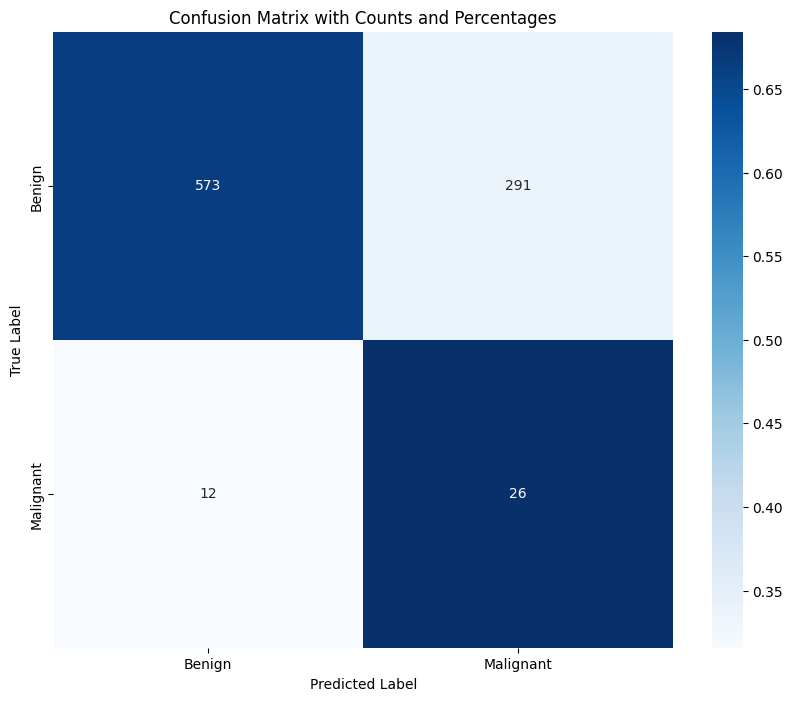

In [60]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pathologies)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', xticklabels=pathologies, yticklabels=pathologies)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()